In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import quandl
from functools import reduce
import math

In [2]:
### Simple Historical Volatility: Pearson Correlation
# def correlation(df):  
# # df --> an n*5 matrix, the time series of 5 subindices
#     corr = df.corr(method = 'pearson')
#     return corr

In [3]:
def EWM_Cov(df, lda):
    '''
    [Input] 
    ###         df : the subindices matrix, with shape (n*5)
    ###        lda : lambda, the smoothing paramater (need to be less than 1)
    [Output]
    ### df_corr_ewm: A dataframe, where every row is the covariance of subindices at time t
    '''
    df_norm = df - 0.5
    df_corr = df_norm**2
    
    df_corr['EM_BM'] = df_norm['EM']*df_norm['BM']
    df_corr['EM_MM'] = df_norm['EM']*df_norm['MM']
    df_corr['EM_FX'] = df_norm['EM']*df_norm['FX']
    df_corr['EM_FI'] = df_norm['EM']*df_norm['FI']
    
    df_corr['BM_MM'] = df_norm['BM']*df_norm['MM']
    df_corr['BM_FX'] = df_norm['BM']*df_norm['FX']
    df_corr['BM_FI'] = df_norm['BM']*df_norm['FI']
    
    df_corr['MM_FX'] = df_norm['MM']*df_norm['FX']
    df_corr['MM_FI'] = df_norm['MM']*df_norm['FI']
    
    df_corr['FX_FI'] = df_norm['FX']*df_norm['FI']
    
    df_corr_ewm = df_corr.ewm(alpha = 1-lda, adjust = False).mean()
    return df_corr_ewm

    ### NOTE!!! 
    ### need to research the details: e.g. the initialization
    

In [4]:
def cov_to_corr(df_corr):
    df_corr['EM_BM'] /= (df_corr['EM']*df_corr['BM'])**0.5
    df_corr['EM_MM'] /= (df_corr['EM']*df_corr['MM'])**0.5
    df_corr['EM_FX'] /= (df_corr['EM']*df_corr['FX'])**0.5
    df_corr['EM_FI'] /= (df_corr['EM']*df_corr['FI'])**0.5
    
    df_corr['BM_MM'] /= (df_corr['BM']*df_corr['MM'])**0.5
    df_corr['BM_FX'] /= (df_corr['BM']*df_corr['FX'])**0.5
    df_corr['BM_FI'] /= (df_corr['BM']*df_corr['FI'])**0.5
    
    df_corr['MM_FX'] /= (df_corr['FX']*df_corr['MM'])**0.5
    df_corr['MM_FI'] /= (df_corr['FI']*df_corr['MM'])**0.5
    
    df_corr['FX_FI'] /= (df_corr['FX']*df_corr['FI'])**0.5
    
    
    
    return df_corr


In [5]:
# from statsmodels.tsa.vector_ar.var_model import VAR

# def weight(df, IPI):
#     '''
#     [Input] 
#     ###  df : the subindices matrix, with shape (n*5)
#     ### IPI : growth of industrial production index, a time series with shape (n*1)
#     '''
    

In [6]:
def weighted_sub(df, weights):
    hadamard = np.multiply(df.loc[i], weight).values
    return hadamard


In [7]:
def get_ciss(df, df_corr):
    '''
    [Input] 
    ###     df : the weighted subindices matrix, with shape (n*5)
    ###  corrs : a time series of 5*5 correlation matrices
    ### weight : a 1*5 array, weight of subindices
    '''
    CISS = pd.Series(index = df.index)
    for i in df.index:
        sub = df.loc[i].values
        arr = df_corr.loc[i,:]   # correlation array
        C = np.matrix([[1, arr.EM_BM, arr.EM_MM, arr.EM_FX, arr.EM_FI], 
                       [arr.EM_BM, 1, arr.BM_MM, arr.BM_FX, arr.BM_FI],
                       [arr.EM_MM, arr.BM_MM, 1, arr.MM_FX, arr.MM_FI],
                       [arr.EM_FX, arr.BM_FX, arr.MM_FX, 1, arr.FX_FI],
                       [arr.EM_FI, arr.BM_FI, arr.MM_FI, arr.FX_FI, 1]])
        CISS.loc[i] = sub.dot(C).dot(sub)
    return CISS

In [8]:
CISS = quandl.get("ECB/CISS_D_U2_Z0Z_4F_EC_SS_CI_IDX", authtoken="GtQacSE7U-s9enx64Yif")
EM = quandl.get("ECB/CISS_D_U2_Z0Z_4F_EC_SS_EM_CON", authtoken="GtQacSE7U-s9enx64Yif")
BM = quandl.get("ECB/CISS_D_U2_Z0Z_4F_EC_SS_BM_CON", authtoken="GtQacSE7U-s9enx64Yif")
MM = quandl.get("ECB/CISS_D_U2_Z0Z_4F_EC_SS_MM_CON", authtoken="GtQacSE7U-s9enx64Yif")
FX = quandl.get("ECB/CISS_D_U2_Z0Z_4F_EC_SS_FX_CON", authtoken="GtQacSE7U-s9enx64Yif")
FI = quandl.get("ECB/CISS_D_U2_Z0Z_4F_EC_SS_FI_CON", authtoken="GtQacSE7U-s9enx64Yif")


In [9]:
CISS.rename(columns = {'Pure number':'CISS'}, inplace = True)
EM.rename(columns = {'Pure number':'EM'}, inplace = True)
BM.rename(columns = {'Pure number':'BM'}, inplace = True)
MM.rename(columns = {'Pure number':'MM'}, inplace = True)
FX.rename(columns = {'Pure number':'FX'}, inplace = True)
FI.rename(columns = {'Pure number':'FI'}, inplace = True)


In [10]:
#EM.plot(figsize = (15,6))
#BM.plot(figsize = (15,6))


In [11]:
CISS.head()


,CISS
Date,
1999-01-08,0.0854
1999-01-10,0.0631
1999-01-15,0.1754
1999-01-22,0.1665
1999-01-29,0.1314


# Result: 
  Since the subindices are never above 0.5, even during the finanical crisis (when CISS is above 0.8), 
  we conclude that the subindices we get is after multiplying their weights.

In [12]:
# Merge multiple dataframes
subindice = [EM, BM, MM, FX, FI]
df_sub = reduce(lambda left,right: pd.merge(left,right,on='Date'), subindice)
df_sub.head()


,EM,BM,MM,FX,FI
Date,,,,,
1999-01-08,0.0778,0.0449,0.0577,0.0725,0.0469
1999-01-10,0.0701,0.0545,0.0634,0.0649,0.0471
1999-01-15,0.1275,0.0666,0.0748,0.0862,0.1192
1999-01-22,0.1194,0.0499,0.0724,0.0460,0.1162
1999-01-29,0.0967,0.0324,0.0526,0.0346,0.0961


In [13]:
ciss_norho = df_sub**2
ciss_norho.head()


,EM,BM,MM,FX,FI
Date,,,,,
1999-01-08,0.006053,0.002016,0.003329,0.005256,0.002200
1999-01-10,0.004914,0.002970,0.004020,0.004212,0.002218
1999-01-15,0.016256,0.004436,0.005595,0.007430,0.014209
1999-01-22,0.014256,0.002490,0.005242,0.002116,0.013502
1999-01-29,0.009351,0.001050,0.002767,0.001197,0.009235


In [14]:
ciss_norho['No_rho_ciss'] = ciss_norho.sum(axis = 1, skipna = True) 
ciss_norho['ori_ciss'] = CISS
ciss_norho['diff'] = ciss_norho['No_rho_ciss'] - ciss_norho['ori_ciss']
ciss_norho.head()

,EM,BM,MM,FX,FI,No_rho_ciss,ori_ciss,diff
Date,,,,,,,,
1999-01-08,0.006053,0.002016,0.003329,0.005256,0.002200,0.018854,0.0854,-0.066546
1999-01-10,0.004914,0.002970,0.004020,0.004212,0.002218,0.018334,0.0631,-0.044766
1999-01-15,0.016256,0.004436,0.005595,0.007430,0.014209,0.047926,0.1754,-0.127474
1999-01-22,0.014256,0.002490,0.005242,0.002116,0.013502,0.037607,0.1665,-0.128893
1999-01-29,0.009351,0.001050,0.002767,0.001197,0.009235,0.023600,0.1314,-0.107800


In [15]:
ciss_norho['diff'].describe()

count    1346.000000
mean       -0.149437
std         0.132510
min        -0.654532
25%        -0.187369
50%        -0.096574
75%        -0.060125
max        -0.018871
Name: diff, dtype: float64

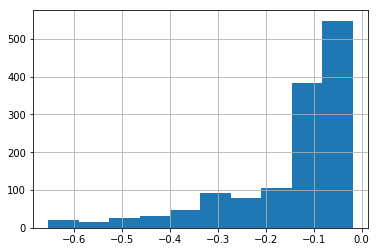

In [16]:
hist = ciss_norho['diff'].hist(bins=10)

In [17]:
'''
from scipy import stats  
import numpy as np  
import matplotlib.pylab as plt

ser = ciss_norho['diff']

# plot normed histogram
plt.hist(ser, bins=10,normed=True)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(ser))

# Normal distribution
m, s = stats.norm.fit(ser) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it

# Gamma Distribution
ag,bg,cg = stats.gamma.fit(ser)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  
plt.plot(lnspc, pdf_gamma, label="Gamma")

# Beta Distribution
ab,bb,cb,db = stats.beta.fit(ser)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label="Beta")

plt.show()  
'''


'\nfrom scipy import stats  \nimport numpy as np  \nimport matplotlib.pylab as plt\n\nser = ciss_norho[\'diff\']\n\n# plot normed histogram\nplt.hist(ser, bins=10,normed=True)\n\n# find minimum and maximum of xticks, so we know\n# where we should compute theoretical distribution\nxt = plt.xticks()[0]  \nxmin, xmax = min(xt), max(xt)  \nlnspc = np.linspace(xmin, xmax, len(ser))\n\n# Normal distribution\nm, s = stats.norm.fit(ser) # get mean and standard deviation  \npdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  \nplt.plot(lnspc, pdf_g, label="Norm") # plot it\n\n# Gamma Distribution\nag,bg,cg = stats.gamma.fit(ser)  \npdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  \nplt.plot(lnspc, pdf_gamma, label="Gamma")\n\n# Beta Distribution\nab,bb,cb,db = stats.beta.fit(ser)  \npdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  \nplt.plot(lnspc, pdf_beta, label="Beta")\n\nplt.show()  \n'

In [18]:
weight = [0.25, 0.15, 0.15, 0.15, 0.30]
df_sub_ori = df_sub.div(weight)
df_sub_ori.head()


,EM,BM,MM,FX,FI
Date,,,,,
1999-01-08,0.3112,0.299333,0.384667,0.483333,0.156333
1999-01-10,0.2804,0.363333,0.422667,0.432667,0.157000
1999-01-15,0.5100,0.444000,0.498667,0.574667,0.397333
1999-01-22,0.4776,0.332667,0.482667,0.306667,0.387333
1999-01-29,0.3868,0.216000,0.350667,0.230667,0.320333


In [19]:
# pre-recursive period for initialzing the corraltion matrix
df_pre = df_sub_ori.loc['1999-01-08':'2002-01-04']


In [20]:
covs = EWM_Cov(df_sub_ori, 0.93)


In [21]:
covs.head()


,EM,BM,MM,FX,FI,EM_BM,EM_MM,EM_FX,EM_FI,BM_MM,BM_FX,BM_FI,MM_FX,MM_FI,FX_FI
Date,,,,,,,,,,,,,,,
1999-01-08,0.035645,0.040267,0.013302,0.000278,0.118107,0.037886,0.021775,0.003147,0.064884,0.023144,0.003344,0.068962,0.001922,0.039636,0.005728
1999-01-10,0.036526,0.038756,0.012789,0.000576,0.118075,0.037335,0.021439,0.003961,0.065615,0.022263,0.003754,0.067416,0.002152,0.038718,0.006944
1999-01-15,0.033976,0.036262,0.011894,0.000926,0.110547,0.034682,0.019938,0.003736,0.060950,0.020710,0.003199,0.063100,0.001995,0.036018,0.005921
1999-01-22,0.031633,0.035684,0.011083,0.003477,0.103698,0.032517,0.018569,0.003778,0.056860,0.019463,0.005240,0.060002,0.002090,0.033633,0.007031
1999-01-29,0.030316,0.038832,0.011868,0.008312,0.098698,0.032491,0.018453,0.005648,0.054304,0.021070,0.010227,0.059374,0.004759,0.033157,0.009926


In [22]:
corrs = cov_to_corr(covs)


In [23]:
corrs.head()


,EM,BM,MM,FX,FI,EM_BM,EM_MM,EM_FX,EM_FI,BM_MM,BM_FX,BM_FI,MM_FX,MM_FI,FX_FI
Date,,,,,,,,,,,,,,,
1999-01-08,0.035645,0.040267,0.013302,0.000278,0.118107,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1999-01-10,0.036526,0.038756,0.012789,0.000576,0.118075,0.992300,0.991950,0.863885,0.999134,0.999996,0.794849,0.996595,0.793149,0.996360,0.842176
1999-01-15,0.033976,0.036262,0.011894,0.000926,0.110547,0.988074,0.991796,0.666259,0.994519,0.997211,0.552151,0.996609,0.601107,0.993289,0.585309
1999-01-22,0.031633,0.035684,0.011083,0.003477,0.103698,0.967830,0.991756,0.360224,0.992783,0.978727,0.470372,0.986387,0.336590,0.992118,0.370272
1999-01-29,0.030316,0.038832,0.011868,0.008312,0.098698,0.946964,0.972842,0.355792,0.992753,0.981471,0.569266,0.959061,0.479131,0.968800,0.346566


In [24]:
ciss_cal = get_ciss(df_sub, corrs)
ciss_cal.head()


Date
1999-01-08    0.089880
1999-01-10    0.084468
1999-01-15    0.198090
1999-01-22    0.141355
1999-01-29    0.084699
dtype: float64

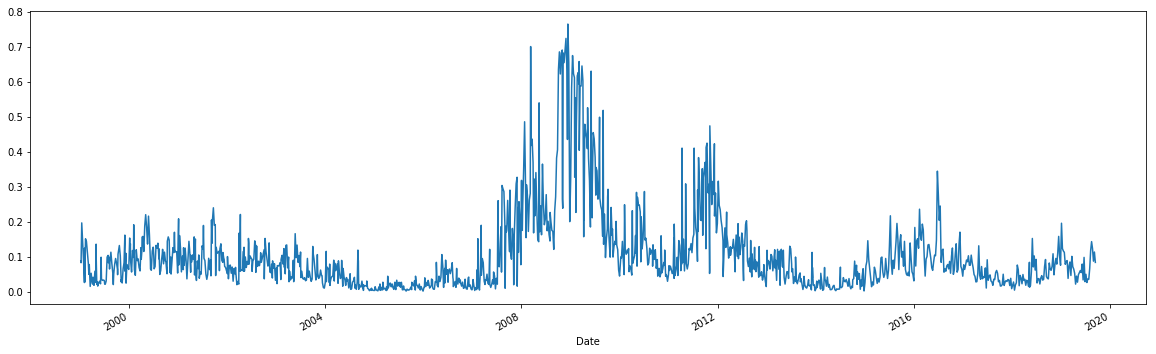

In [25]:
ciss_cal.plot(figsize = (20,6))


In [26]:
ciss_cal = ciss_cal.to_frame(name = 'Calculated CISS')
ciss_cal.head()


,Calculated CISS
Date,
1999-01-08,0.089880
1999-01-10,0.084468
1999-01-15,0.198090
1999-01-22,0.141355
1999-01-29,0.084699


In [38]:
ciss_cal.to_csv('/Users/guapofish/Desktop/ciss_cal.csv')


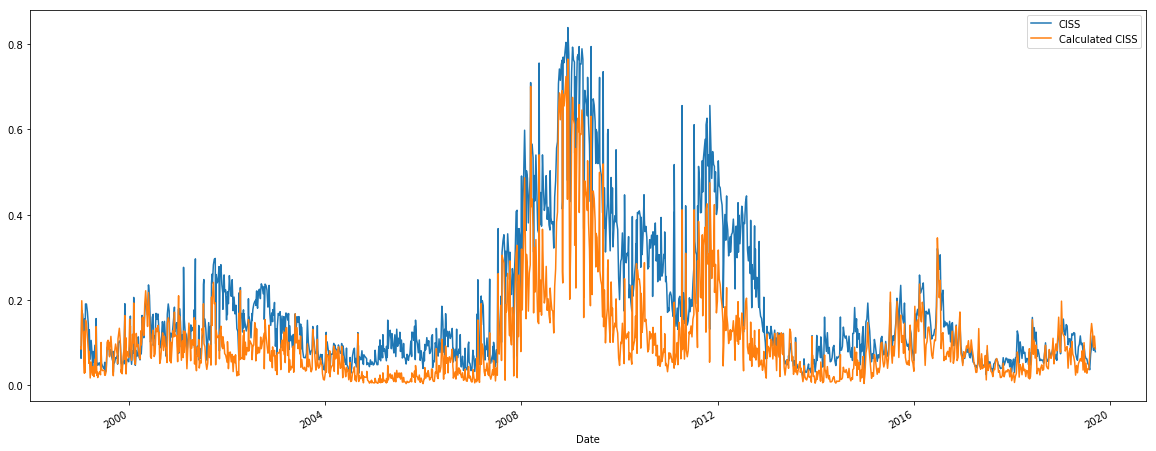

In [28]:
ciss_comp = pd.merge(CISS, ciss_cal, on = 'Date')
ciss_comp.plot(figsize = (20,8))


In [29]:
def EWM_Corrs(df, lda):
    '''
    [Input] 
    ###         df : the subindices matrix, with shape (n*5)
    ###        lda : lambda, the smoothing paramater (need to be less than 1)
    [Output]
    ### df_corr_ewm: A dataframe, where every row is the covariance of subindices at time t
    '''
    df_norm = df - 0.5
    df_corr_ewm = df_norm.ewm(alpha = 1-lda, adjust = False).corr()
    return df_corr_ewm

In [30]:
def get_ciss_2(df, corrs):
    '''
    [Input] 
    ###     df : the weighted subindices matrix, with shape (n*5)
    ###  corrs : a time series of 5*5 correlation matrices
    ### weight : a 1*5 array, weight of subindices
    '''
    CISS = pd.Series(index = df.index)
    for i in df.index:
        hadamard = df.loc[i].values
        C = corrs.loc[i,:].values
        CISS.loc[i] = hadamard.dot(C).dot(hadamard)
    return CISS

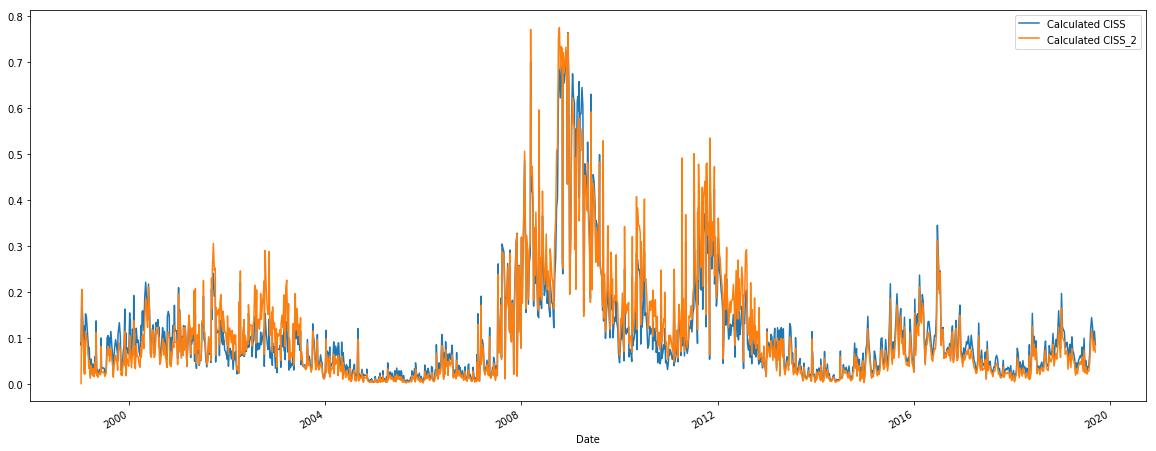

In [31]:
corrs_2 = EWM_Corrs(df_sub_ori, 0.93)
ciss_cal_2 = get_ciss_2(df_sub, corrs_2, )
ciss_cal_2 = ciss_cal_2.to_frame(name = 'Calculated CISS_2')

ciss_cal_comp = pd.merge(ciss_cal, ciss_cal_2, on = 'Date')
ciss_cal_comp.plot(figsize = (20,8))

In [32]:
(ciss_cal['Calculated CISS'] == ciss_cal_2['Calculated CISS_2']).sum()


0

In [33]:
ciss_cal['Calculated CISS'] - ciss_cal_2['Calculated CISS_2']


Date
1999-01-08         NaN
1999-01-10    0.083568
1999-01-15   -0.008055
1999-01-22    0.025524
1999-01-29    0.023220
1999-02-04    0.006355
1999-02-05    0.031221
1999-02-07    0.007567
1999-02-12    0.039209
1999-02-19    0.038123
1999-02-26    0.032505
1999-03-05    0.025834
1999-03-09    0.017335
1999-03-12    0.028635
1999-03-19    0.004382
1999-03-26    0.013329
1999-04-02    0.006916
1999-04-06    0.004881
1999-04-09    0.009879
1999-04-16    0.004099
1999-04-23    0.011879
1999-04-30    0.005485
1999-05-02    0.025084
1999-05-03    0.017582
1999-05-07    0.004305
1999-05-11    0.006940
1999-05-14    0.003380
1999-05-21    0.004795
1999-05-28    0.006445
1999-06-04    0.004657
                ...   
2019-02-22    0.007508
2019-03-01    0.017255
2019-03-08    0.021469
2019-03-15    0.012176
2019-03-22    0.025816
2019-03-29    0.017937
2019-04-05    0.016040
2019-04-12    0.012598
2019-04-19    0.004549
2019-04-26    0.012446
2019-05-03    0.006859
2019-05-10    0.011135
2019-0

In [34]:
ciss_comp.head()

,CISS,Calculated CISS
Date,,
1999-01-08,0.0854,0.089880
1999-01-10,0.0631,0.084468
1999-01-15,0.1754,0.198090
1999-01-22,0.1665,0.141355
1999-01-29,0.1314,0.084699


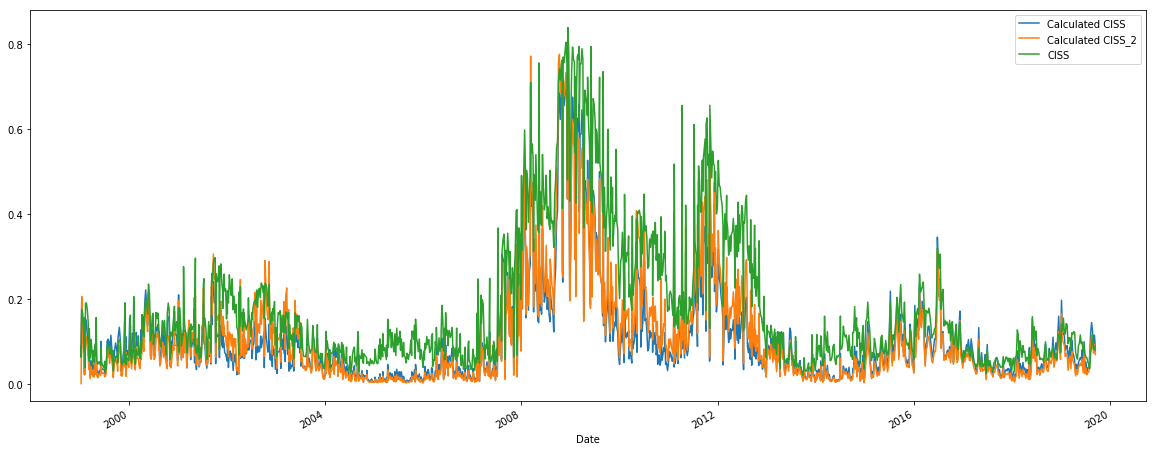

In [35]:
ciss_comp = pd.merge(ciss_cal_comp, CISS, on = 'Date')
ciss_comp.plot(figsize = (20,8))

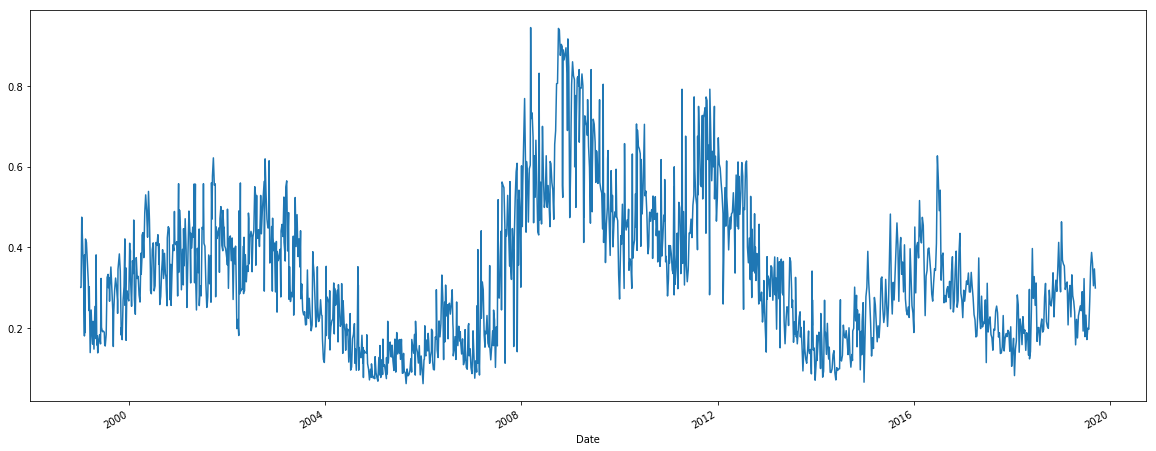

In [36]:
# simply sum the weighted subindices, to see the importance of the covariance matrix
ciss_cal2 = df_sub.sum(axis = 1)
ciss_cal2.plot(figsize = (20,8))